# Inference of parameters (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.


In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time 

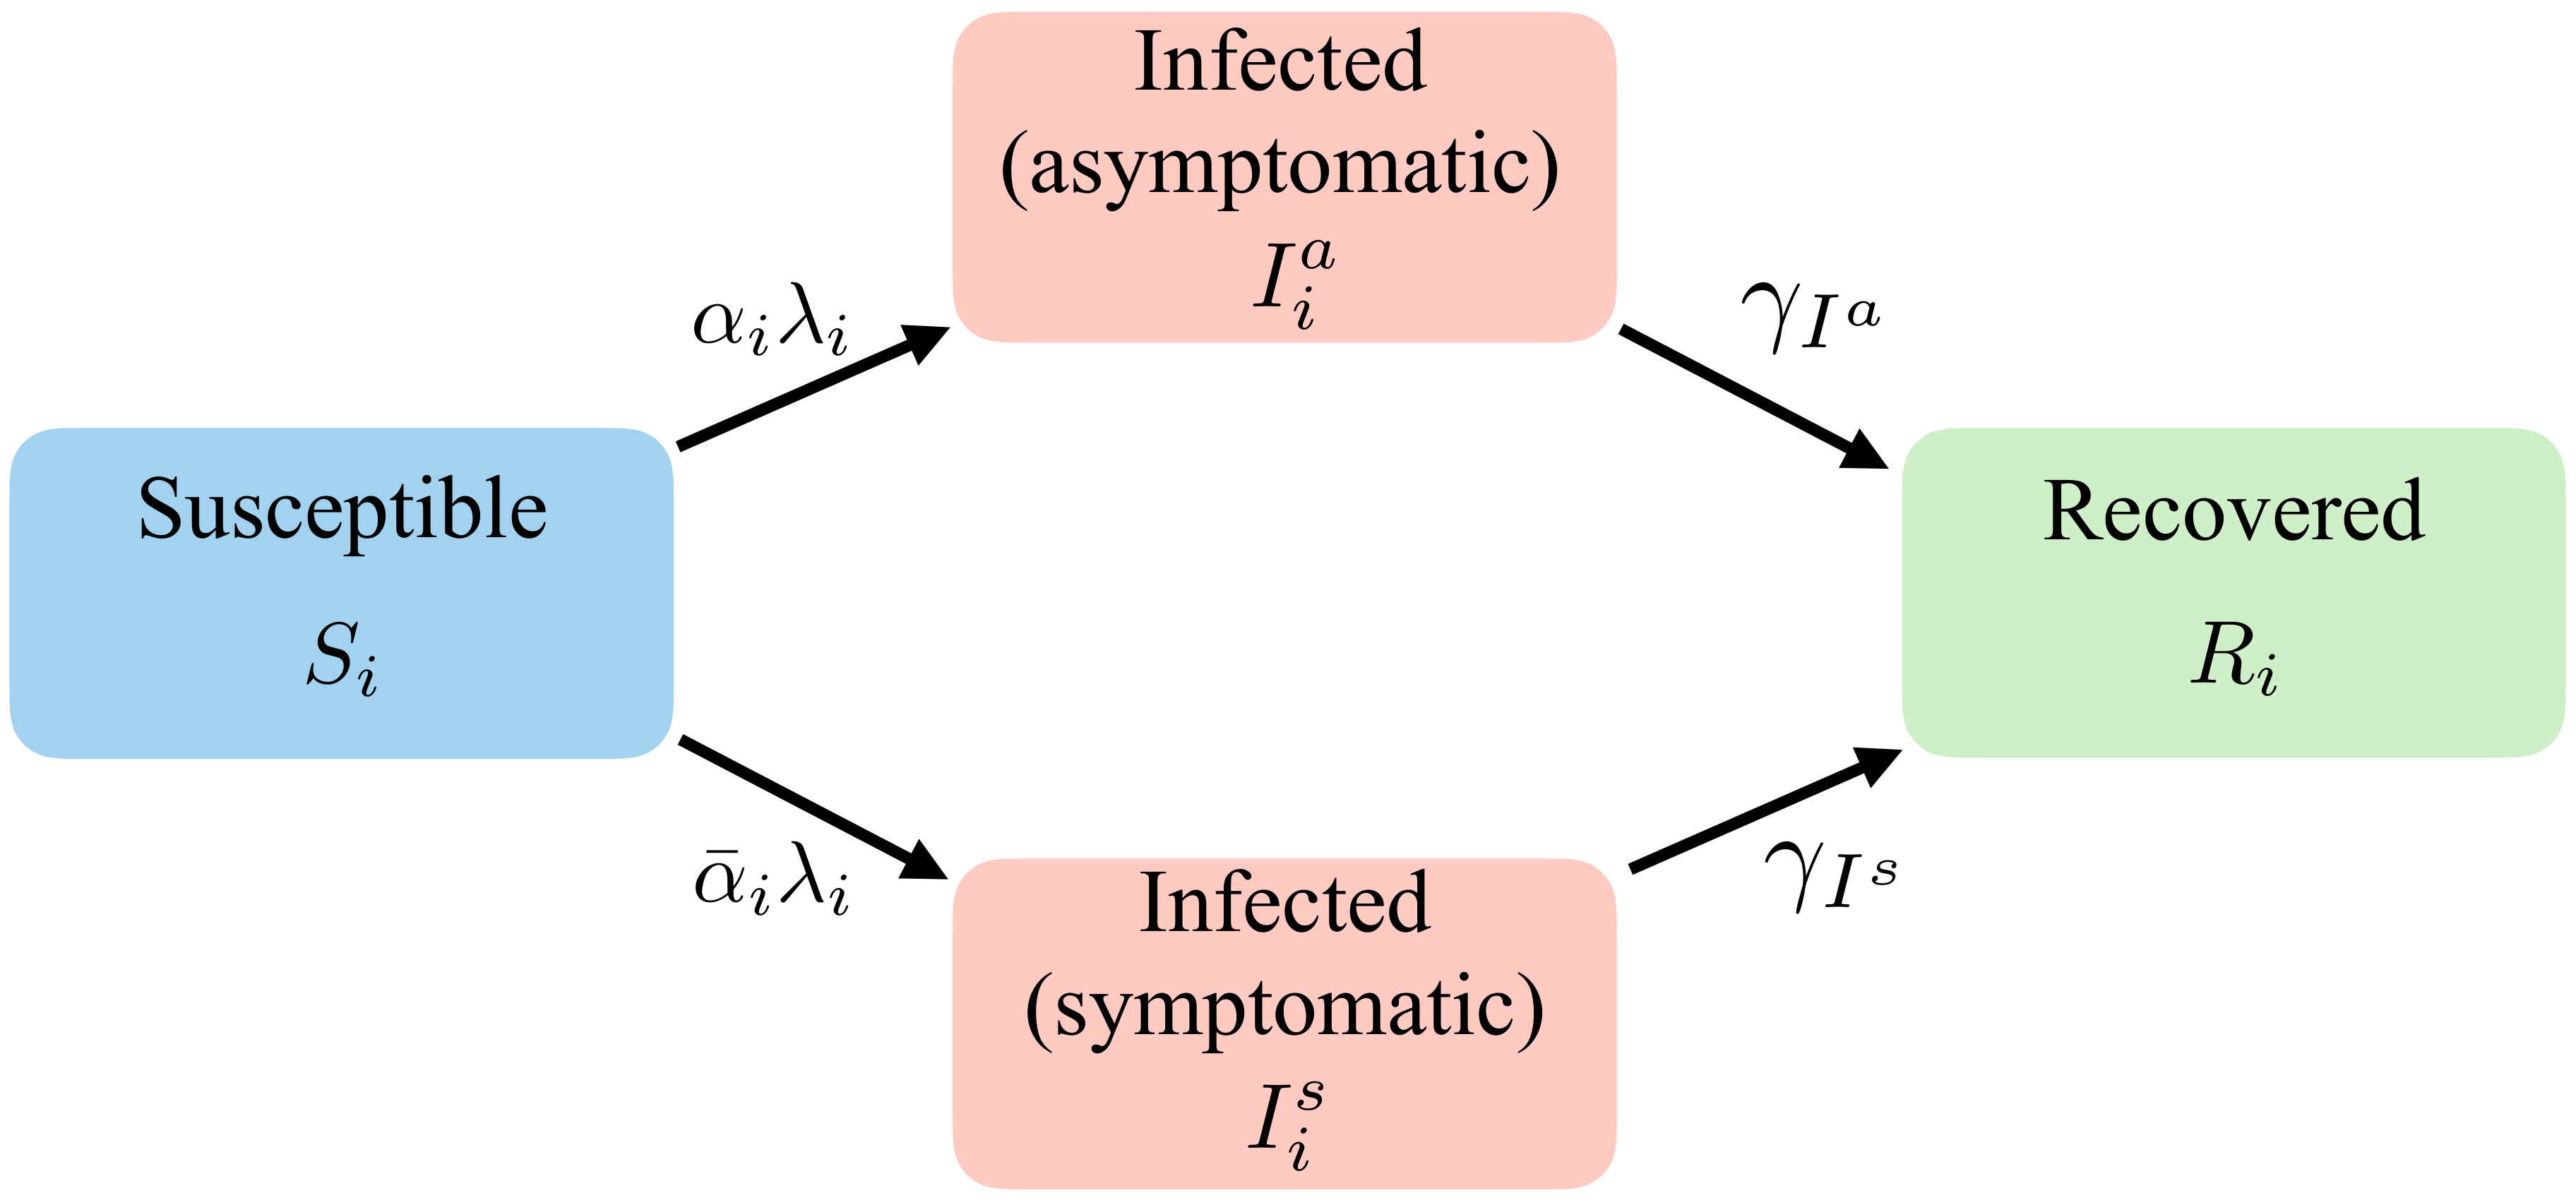

In [3]:
from IPython.display import Image
Image('SIIR.jpg')

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [51]:
M = 2                # the population has two age groups
N = 1e6              # and this is the total population

# parameters for generating synthetic trajectory 
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], 
              [3., 12.]]) 
# C_ij = number of people group from group i that an individual from group j meets per day 

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([2, 2])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau-leaping')
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

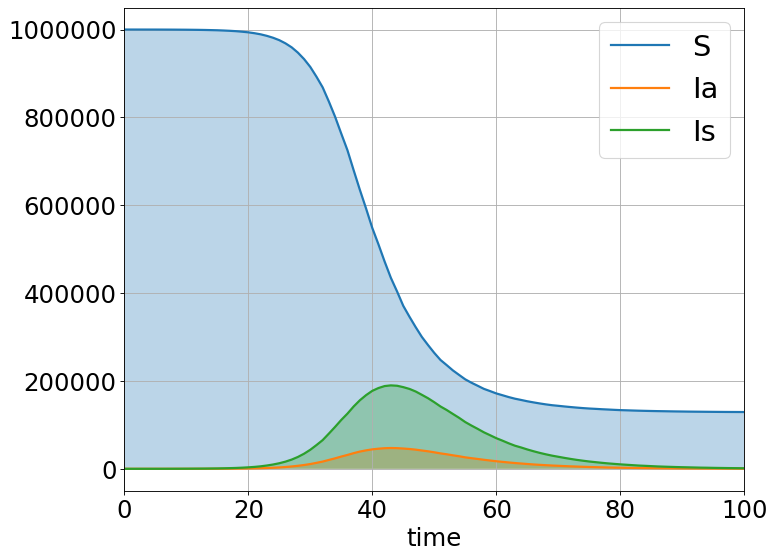

In [52]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $20$ data points of the trajectories and use it to infer the parameters of the model.

In [53]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x)[:Nf_inference]

steps = 5
estimator = pyross.inference.SIR(parameters, M, Ni, 1, steps)

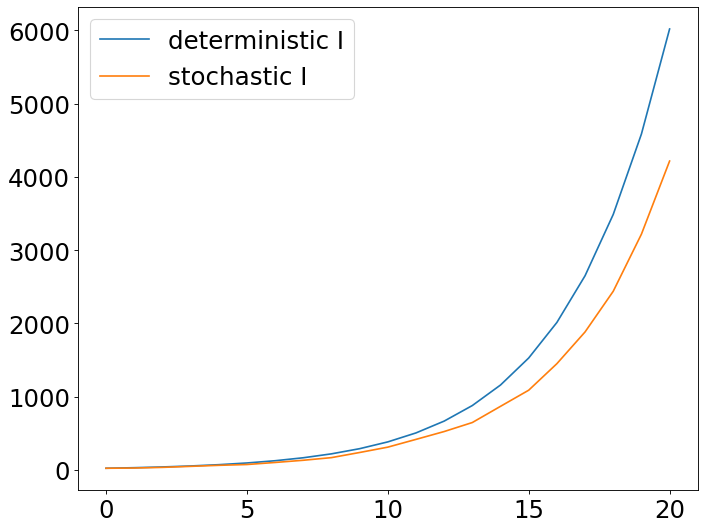

In [54]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
x0=x[0]
det_model = estimator.make_det_model(parameters)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(xm[:, M:], axis=1), label='deterministic I')
plt.plot(np.sum(x[:Nf_inference, M:], axis=1), label='stochastic I')
plt.legend()
plt.show()

In [55]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use faster ODE methods to speed up inference 
estimator.set_lyapunov_method('RK2')
estimator.set_det_method('euler')

logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix, tangent=False)
end_time = time.time()
print(logp) 
print(end_time - start_time)

373.9840899181759
0.07316470146179199


In [56]:
# compare to tangent space 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

390.04876518779395
0.005573749542236328


In [57]:
# Define the prior (log normal prior around guess of parameter with defined std. deviation)
alpha_g = 0.25
beta_g = 0.04
gIa_g = 0.1
gIs_g = 0.1


# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
print(logp) 

1537.7665782373092


In [58]:
# the names of the parameters to be inferred 
keys = ['alpha', 'beta', 'gIa', 'gIs']

# initial guess 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])  

# error bars on the initial guess 
alpha_std = 0.2
beta_std = 0.1
gIa_std = 0.2
gIs_std = 0.2
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std])

eps = 1e-4
# bounds on the parameters 
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) 

# Stopping criterion for minimisation (realtive change in function value)
ftol = 1e-6  
start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, 
                                    tangent=False, 
                                    global_max_iter=20,
                                    local_max_iter=400,
                                    cma_population=32,  
                                    global_atol=10,
                                    ftol=ftol, 
                                    verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 4 (seed=241988031, Mon Jun 22 09:58:00 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     32 6.001645298514683e+02 1.0e+00 8.73e-01  8e-02  2e-01 0:00.7
    2     64 1.184143447981365e+03 1.2e+00 7.32e-01  6e-02  1e-01 0:01.3
    3     96 8.121459037154623e+02 1.5e+00 6.94e-01  5e-02  1e-01 0:01.9
   10    320 3.880731756748671e+02 6.4e+00 4.37e-01  4e-03  6e-02 0:05.0
   19    608 3.693184220178296e+02 2.3e+01 1.67e-01  3e-04  1e-02 0:09.1
Optimal value (global minimisation):  369.2759727636859
Starting local minimisation...
Optimal value (local minimisation):  369.1672845656965
[0.19828296 0.01976663 0.13632623 0.14390218]
10.533324718475342


In [59]:
# compute log_p for best estimate 
start_time = time.time() 
new_parameters = estimator.fill_params_dict(keys, params)
logp = estimator.obtain_minus_log_p(new_parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

373.6677935038686
0.05761909484863281


In [60]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

Inferred parameters:
{'alpha': 0.19828295958603886, 'beta': 0.019766627730984445, 'gIa': 0.13632622552136442, 'gIs': 0.1439021820724015, 'fsa': array([1., 1.])}


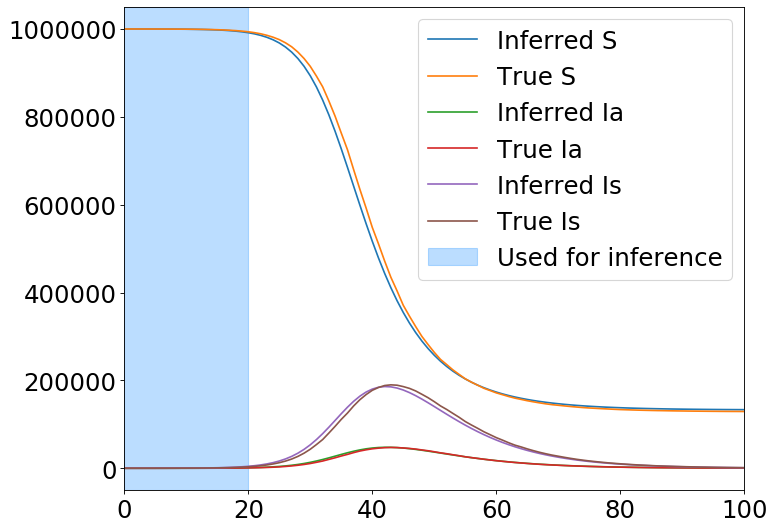

In [62]:
x = np.load('SIR_sto_traj.npy').astype('float') 
Nf = x.shape[0]
Tf = Nf-1

det_model = estimator.make_det_model(new_parameters)

# set the deterministic method to be solve_ivp for accurate integration over long time scale 
estimator.set_det_method('LSODA')

x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 

In [63]:
hess = estimator.compute_hessian(keys, params, guess, stds, x, Tf_inference, Nf_inference, contactMatrix, eps=1.e-3, tangent=False,
                        fd_method="central")

In [64]:
cov = np.linalg.inv(hess)

In [75]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 
              'gIs': params[3], 'fsa':fsa,
               'cov':cov}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SIR(parameters, M, Ni)

In [83]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[Nf_inference,:M]
Ia0_forecast = x[Nf_inference,M:2*M]
Is0_forecast = x[Nf_inference,2*M:]

print(Ia0_forecast, Is0_forecast)

# Number of simulations over which we average, use 500
Ns = 100

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, Ia0_forecast, Is0_forecast, 
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                         verbose=True, method='deterministic',
                                        Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

[571. 568.] [2165. 2186.]
Finished. Time needed for evaluation: 00:00:00


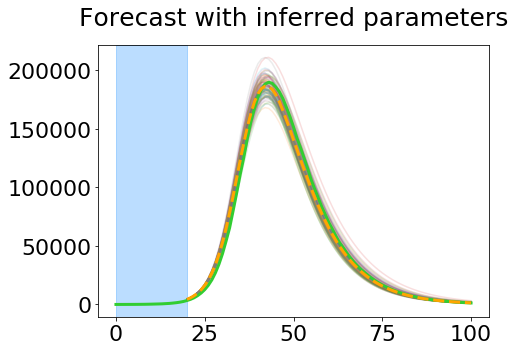

In [84]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = trajectories_forecast[:,4] + trajectories_forecast[:,5]
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = data_array[:,4] + data_array[:,5]

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)